In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
from numba import jit, cuda
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float64
import math

In [2]:
start = time.time()

In [3]:
history = 300 #specify the number of particles at the beginning
dummy_history = 5000
radius = 5
r_host = np.float64(np.full((dummy_history, 2), -11000))
r = cuda.to_device(r_host)

@cuda.jit
def initialize_particles(rng_states, r, history):
    thread_id = cuda.grid(1)
    if thread_id < history:
        teta = xoroshiro128p_uniform_float64(rng_states, thread_id)*2*np.pi
        position = xoroshiro128p_uniform_float64(rng_states, thread_id)*radius
        r[thread_id, 0] = position * math.sin(teta)
        r[thread_id, 1] = position * math.cos(teta)

In [4]:
threads_per_block = 300
blocks = (dummy_history+threads_per_block-1) // threads_per_block
rng_states = create_xoroshiro128p_states(threads_per_block * blocks, seed=1)

# Launch the kernel
initialize_particles[blocks, threads_per_block](rng_states, r, history)

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 17 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [5]:
r_host = r.copy_to_host()

In [6]:
r_host

array([[ 1.40309390e+00,  1.26671061e+00],
       [-7.37127714e-01,  7.49727878e-01],
       [-1.64448605e+00,  1.56562462e+00],
       ...,
       [-1.10000000e+04, -1.10000000e+04],
       [-1.10000000e+04, -1.10000000e+04],
       [-1.10000000e+04, -1.10000000e+04]])

In [7]:
fps = 20
dt = 1/fps
final_time = 200
steps = int(final_time/dt)

In [8]:
record_host = np.float64(np.full((steps, dummy_history, 2), -11000))
record_host[0,:,:] = r_host[:,:]
record = cuda.to_device(record_host)

In [9]:
fr = np.float64(1)
fuel_host = np.full((1, 2), np.nan)

def initialize_fuel(fuel_host):
    fuel_host[0, 0] = 0
    fuel_host[0, 1] = 0

In [10]:
initialize_fuel(fuel_host)
fuel = cuda.to_device(fuel_host)

In [11]:
speed = 1
v_host = np.float64(np.full((dummy_history, 2), np.nan))
v = cuda.to_device(v_host)

@cuda.jit
def initialize_speed(rng_states, v, dummy_history):
    thread_id = cuda.grid(1)
    if thread_id < dummy_history:
        teta = xoroshiro128p_uniform_float64(rng_states, thread_id)*2*np.pi
        v[thread_id, 0] = speed * math.cos(teta)
        v[thread_id, 1] = speed * math.sin(teta)

In [12]:
initialize_speed[blocks, threads_per_block](rng_states, v, dummy_history)

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 17 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [13]:
@cuda.jit
def update_particle1(i, dummy_history, r, v, fuel, fr, collision, record):
    thread_id = cuda.grid(1)
    if thread_id < dummy_history:
        if r[thread_id, 0] == -11000 or r[thread_id, 0] == 11000:
            pass
        elif (fuel[0, 0] - fr <= r[thread_id, 0] <= fuel[0, 0] + fr and
              fuel[0, 1] - fr <= r[thread_id, 1] <= fuel[0, 1] + fr and
              math.sqrt(r[thread_id, 0]**2 + r[thread_id, 1]**2) <= fr):
            r[thread_id,:] = 11000
            #v[thread_id,:] = 0
            collision[thread_id] = 1
        elif math.sqrt(r[thread_id, 0]**2 + r[thread_id, 1]**2) < radius:
            for k in range(r.shape[1]):
                r[thread_id, k] = r[thread_id, k] + v[thread_id, k] * np.float64(dt)
        else:
            distance_to_origin = math.sqrt(r[thread_id, 0]**2 + r[thread_id, 1]**2)
            normal_vectorx = r[thread_id, 0] / distance_to_origin
            normal_vectory = r[thread_id, 1] / distance_to_origin
            dot_product = v[thread_id, 0] * normal_vectorx + v[thread_id, 1] * normal_vectory
            v[thread_id, 0] -= 2 * dot_product * normal_vectorx
            v[thread_id, 1] -= 2 * dot_product * normal_vectory
            for k in range(r.shape[1]):
                r[thread_id, k] = r[thread_id, k] + v[thread_id, k] * np.float64(dt)
        for j in range(2):
            record[i,thread_id,j] = r[thread_id,j]

In [14]:
@jit(nopython=True)
def update_particle2(r_host):
    born_part = 2
    for i in range(dummy_history):
        if born_part == 0:
            break
        if r_host[i,0] == 11000. or r_host[i,0] == -11000.:
            teta = np.random.uniform(0, 2*np.pi)
            position = np.random.uniform(0, radius)
            r_host[i, 0] = position * math.sin(teta)
            r_host[i, 1] = position * math.cos(teta)
            born_part = born_part-1
        else: continue

In [15]:
for i in range(1,steps):
    collision_host = np.full((dummy_history), 0)
    collision = cuda.to_device(collision_host)
    update_particle1[blocks, threads_per_block](i, dummy_history, r, v, fuel, fr, collision, record)
    collision_host = collision.copy_to_host()
    r_host = r.copy_to_host()
    for k in range(dummy_history):
        if collision_host[k] == 1:
            update_particle2(r_host)
    r = cuda.to_device(r_host)

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 17 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [16]:
record_host = record.copy_to_host()

In [17]:
end = time.time()
print(f'duration = {end-start}')

duration = 17.80283784866333


In [18]:
part = 0
for i in range(dummy_history):
    if record_host[3999,i,0] != 11000 and record_host[3999,i,0] != -11000:
        part +=1
        print(i)
print('Particles =', part)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

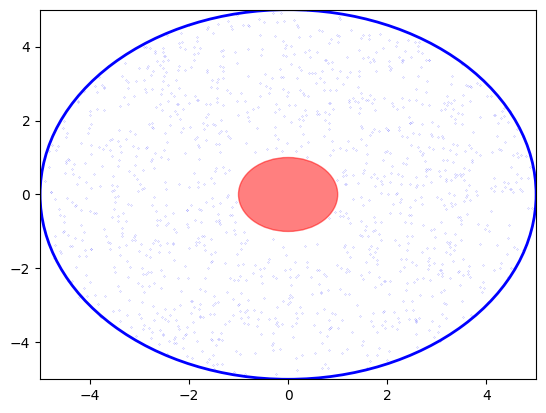

In [19]:
# Create a figure and axis for the animation
fig, ax = plt.subplots()
ax.set_xlim(-radius, radius)
ax.set_ylim(-radius, radius)

# Create a scatter plot for the particles with a specified size (e.g., ms=2)
particles, = ax.plot([], [], 'bo', ms=0.1)

# Create cylinder boundary
cylinder = plt.Circle((0, 0), radius, color='b', fill=False, lw=2)
ax.add_patch(cylinder)

# Create fuel region
fuel_region = plt.Circle((0, 0), fr, color='red', alpha=0.5)
ax.add_patch(fuel_region)

# Function to initialize the plot
def init():
    particles.set_data([], [])
    return particles,

# Function to update particle positions for each frame
def update(frame):
    x_data = record_host[frame,:,0].copy()
    y_data = record_host[frame,:,1].copy()
    particles.set_data(x_data, y_data)
    return particles,

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(record_host), init_func=init, interval=50, blit=True)

# Set up the animation writer (for saving as a GIF)
Writer = animation.writers['pillow']
writer = Writer(fps=fps, metadata=dict(artist='Me'), bitrate=180)

# Save the animation as a GIF
ani.save('particle_animation.gif', writer=writer)

# Display the animation
plt.show()
